# Newton Fractal — generate Fortran code from SymPy

In this notebook you define a SymPy expression `f(z)`. The notebook generates only the Fortran fragments that change when you edit `f` (the evaluation of `f` and `f'`) and embeds them into a static Fortran template that writes a PGM image of the Newton fractal.

Workflow:
1. Define `f(z)` as a SymPy expression (example: `z**3 - 1`).
2. Notebook generates Fortran fragments for Re(f), Im(f), Re(f'), Im(f').
3. These fragments are inserted into a static Fortran template.
4. Output: a static Fortran file `newton_fractal_static.f90` and a dynamic include `newton_dynamic.inc` you can compile.

Note: SymPy is required. If not installed, run:
```bash
python -m pip install sympy
```
To compile the generated Fortran code you need a Fortran compiler like `gfortran`. You can also inspect the generated code without compiling.

In [ ]:
# Imports
import sympy as sp
from sympy import I, fcode
from textwrap import dedent
from macrofor import api as mf
import pathlib
print('SymPy version:', sp.__version__)

## 1) Parameters and function definition
Define image size and coordinate window below. Edit `f(z)` to change the function (e.g. `z**3 - 1`).

In [ ]:
# User-configurable parameters
width = 800
height = 800
xmin = -1.5
xmax =  1.5
ymin = -1.5
ymax =  1.5
maxiter = 50

# === Define the complex function f(z) here ===
z = sp.symbols('z')
f = z**3 - 1    # <-- edit this line to change the function
# ==========================================
f

## 2) Build SymPy expressions for Re/Im of f and f' (in x,y)
We substitute `z = x + i*y` and extract the real and imaginary parts for `f` and `f'`.

In [ ]:
# symbolic variables
x, y = sp.symbols('x y', real=True)
z_xy = x + I*y

# f and derivative f'
f_xy = sp.simplify(f.subs(z, z_xy))
df = sp.diff(f, z)
df_xy = sp.simplify(df.subs(z, z_xy))

# explicit real and imaginary parts
re_f = sp.re(f_xy)
im_f = sp.im(f_xy)
re_df = sp.re(df_xy)
im_df = sp.im(df_xy)

print('f(z) =', f)
print('Re(f) =', re_f)
print('Im(f) =', im_f)

print('df(z) =', df)
print('Im(f) =', im_df)
print('Re(f) =', re_df)

## 3) Convert SymPy expressions to Fortran RHS strings and wrap with macrofor helpers
We use `sympy.fcode` to generate Fortran expressions and then `macrofor.api.equalf` to produce assignment lines. Only these lines are written to the dynamic include file.

In [ ]:
def fortran_rhs(expr):
    # produce a Fortran assignment to a temporary name and extract the RHS
    s = fcode(expr, assign_to='TMP', source_format='free')
    rhs = s.split('=',1)[1].strip()
    return rhs

# Build assignment RHS strings
a_rhs = fortran_rhs(re_f)
b_rhs = fortran_rhs(im_f)
c_rhs = fortran_rhs(re_df)
d_rhs = fortran_rhs(im_df)

# Wrap with macrofor helpers to produce canonical assignment lines
a_line = mf.equalf('a', a_rhs)
b_line = mf.equalf('b', b_rhs)
c_line = mf.equalf('c', c_rhs)
d_line = mf.equalf('d', d_rhs)

dynamic_lines = [a_line, b_line, c_line, d_line]
dynamic_text = "\n".join(dynamic_lines) + "\n"

print('Generated dynamic fragment (for include file):')
print(dynamic_text)

## 4a) Write dynamic include and static Fortran file
The static file contains the Newton iteration, grid setup and PGM dump. The dynamic include (`newton_dynamic.inc`) contains only the `a=...`, `b=...`, `c=...`, `d=...` assignments produced above.

In [ ]:
# Paths
notebook_dir = pathlib.Path('.')
dyn_path = notebook_dir / 'newton_dynamic.inc'
static_path = notebook_dir / 'newton_fractal_static.f90'

# Write dynamic include
dyn_path.write_text(dynamic_text)
print('Wrote dynamic include:', dyn_path.resolve())

# Static Fortran template (uses include to import a,b,c,d evaluations)
static_template = dedent(f'''
program newton_fractal
  implicit none
  integer, parameter :: width = {width}, height = {height}
  integer :: i, j, iter, maxiter
  double precision :: xmin, xmax, ymin, ymax
  double precision :: zr, zi, nz_re, nz_im
  double precision :: a, b, c, d, denom, nr, ni
  double precision :: x, y
  double precision :: tol, dist
  integer :: val
  integer, dimension(width,height) :: img

  tol = 1.0d-8

  xmin = {xmin}d0
  xmax = {xmax}d0
  ymin = {ymin}d0
  ymax = {ymax}d0
  maxiter = {maxiter}

  do j = 1, height
    do i = 1, width
      zr = xmin + (i-1) * (xmax - xmin) / (width - 1)
      zi = ymin + (j-1) * (ymax - ymin) / (height - 1)
      x = zr
      y = zi
      iter = 0
      do while (iter < maxiter)
        ! include dynamic evaluation of f and f' (a,b,c,d)
        include 'newton_dynamic.inc'
        ! static Newton update (expressed with a,b,c,d)
        denom = c*c + d*d
        nr = a*c + b*d
        ni = b*c - a*d
        nz_re = zr - nr/denom
        nz_im = zi - ni/denom
        ! Check convergence
        dist = sqrt((nz_re - zr)**2 + (nz_im - zi)**2)
        if (dist < tol) exit
        zr = nz_re
        zi = nz_im
        x = zr
        y = zi
        iter = iter + 1
      end do
      val = int(255.0d0 * iter / maxiter)
      img(i,j) = val
    end do
  end do

  open(unit=10, file='newton_out.pgm', status='replace')
  write(10,*) 'P2'
  write(10,*) width, height
  write(10,*) 255
  do j = 1, height
    do i = 1, width
      write(10,'(I3,1X)', advance='no') img(i,j)
    end do
    write(10,*)
  end do
  close(10)
end program newton_fractal
''')

fortran_source = static_template
static_path.write_text(fortran_source)
print('Wrote static Fortran file:', static_path.resolve())

## 4b) Using genfor() and macro-statements to write the complete program to a file

The `genfor(filename, statements_list)` function makes it easy to write the entire generated Fortran program directly to a file. This is cleaner and more maintainable than string templates:

In [ ]:
def generate_newton_with_genfor():
    """
    Generate the complete Newton fractal program using macrofor and write it 
    directly to a file using genfor().
    """
    from macrofor.api import genfor
    
    # Build all program components
    decls = [
        # declare width/height as parameters so img can use them as constant bounds
        f"integer, parameter :: width = {width}, height = {height}",
        mf.declarem('integer', ['i', 'j', 'iter', 'maxiter']),
        mf.declarem('double precision', ['xmin', 'xmax', 'ymin', 'ymax']),
        mf.declarem('double precision', ['zr', 'zi', 'nz_re', 'nz_im']),
        mf.declarem('double precision', ['a', 'b', 'c', 'd', 'denom', 'nr', 'ni']),
        mf.declarem('double precision', ['x', 'y', 'tol', 'dist']),
        mf.declarem('integer', ['val']),
        'integer, dimension(width,height) :: img',
    ]
    
    inits = [
        mf.equalf('tol', '1.0d-8'),
        mf.equalf('xmin', f'{xmin}d0'),
        mf.equalf('xmax', f'{xmax}d0'),
        mf.equalf('ymin', f'{ymin}d0'),
        mf.equalf('ymax', f'{ymax}d0'),
        mf.equalf('maxiter', f'{maxiter}'),
    ]
    
    newton_body = [
        mf.equalf('zr', 'xmin + (i-1) * (xmax - xmin) / (width - 1)'),
        mf.equalf('zi', 'ymin + (j-1) * (ymax - ymin) / (height - 1)'),
        mf.equalf('x', 'zr'),
        mf.equalf('y', 'zi'),
        mf.equalf('iter', '0'),
        'do while (iter < maxiter)',
        '  include "newton_dynamic.inc"',
        '  denom = c*c + d*d',
        '  nr = a*c + b*d',
        '  ni = b*c - a*d',
        '  nz_re = zr - nr/denom',
        '  nz_im = zi - ni/denom',
        '  dist = sqrt((nz_re - zr)**2 + (nz_im - zi)**2)',
        '  if (dist < tol) exit',
        '  zr = nz_re',
        '  zi = nz_im',
        '  x = zr',
        '  y = zi',
        '  iter = iter + 1',
        'end do',
        mf.equalf('val', 'int(255.0d0 * iter / maxiter)'),
        'img(i,j) = val',
    ]
    
    loops = mf.dom('j', '1', 'height', [
        mf.dom('i', '1', 'width', newton_body)
    ])
    
    write_block = [
        'write(10,*) "P2"',
        'write(10,*) width, height',
        'write(10,*) 255',
        mf.dom('j', '1', 'height', [
            mf.dom('i', '1', 'width', ["write(10,'(I3,1X)', advance='no') img(i,j)"]),
            'write(10,*)'
        ])
    ]
    
    file_block = mf.openm('10', 'newton_out.pgm', 'replace', write_block)
    
    # Complete program
    prog = mf.programm('newton_fractal', decls + inits + [loops, file_block])
    
    # Use genfor() to write the complete program to a file!
    output_path = pathlib.Path('newton_fractal_genfor.f90')
    genfor(output_path, [prog])
    
    print('✓ Wrote complete Newton program using genfor():', output_path.resolve())
    print('\nProgram preview (first 50 lines):')
    print('---' * 20)
    # prog is a list/structure; convert to string via reading the generated file for preview
    try:
        with open(output_path, 'r') as f:
            lines = f.readlines()
    except Exception:
        lines = []
    for i, line in enumerate(lines[:50], 1):
        print(f"{i:3d}: {line.rstrip()}")
    if len(lines) > 50:
        print('...')
    print('---' * 20)
    return output_path

output = generate_newton_with_genfor()

## 5) Compile & run (examples)
Use your Fortran compiler (e.g. `gfortran`). Example commands for PowerShell (Windows):
```powershell
gfortran newton_fractal_static.f90 -o newton_fractal.exe
.\newton_fractal.exe
```

or Bash (Linux)
```bash
gfortran newton_fractal_static.f90 -o newton_fractal
./newton_fractal
```

The program will write `newton_out.pgm` in the same folder.

## 6) Preview the generated PGM (after compile & run)
If `newton_out.pgm` has been generated you can display it using Python/Pillow:

In [ ]:
from PIL import Image
img_path = pathlib.Path('newton_out.pgm')
if img_path.exists():
    im = Image.open(img_path)
    display(im)
else:
    print('File newton_out.pgm not found. Compile and run the Fortran program to generate it.')

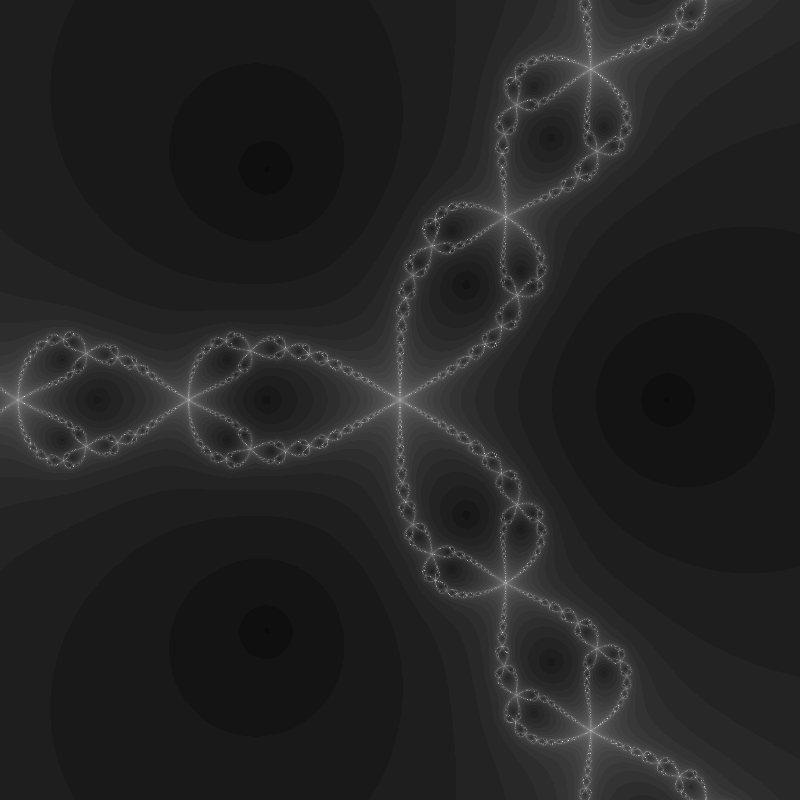

✓ Loaded Newton fractal image: 800×800 pixels


In [35]:
import numpy as np
from PIL import Image

img_path = pathlib.Path('newton_out.pgm')
if img_path.exists():
    # Read the PGM file manually
    with open(img_path, 'r') as f:
        lines = f.readlines()
    
    # Parse header
    header_idx = 0
    magic = lines[header_idx].strip()
    header_idx += 1
    
    # Skip comments
    while lines[header_idx].startswith('#'):
        header_idx += 1
    
    # Read dimensions
    dims = lines[header_idx].strip().split()
    width, height = int(dims[0]), int(dims[1])
    header_idx += 1
    
    # Read max value
    maxval = int(lines[header_idx].strip())
    header_idx += 1
    
    # Read pixel data
    pixels = []
    for line in lines[header_idx:]:
        pixels.extend(line.split())
    
    # Convert to numpy array and reshape
    img_array = np.array([int(p) for p in pixels], dtype=np.uint8)
    img_array = img_array.reshape((height, width))
    
    # Create PIL Image and display
    im = Image.fromarray(img_array, mode='L')
    display(im)
    print(f'✓ Loaded Newton fractal image: {width}×{height} pixels')
else:
    print('File newton_out.pgm not found. Compile and run the Fortran program to generate it.')

---
Notes / extensions:
- Splitting static and dynamic code via `include` is a quick way to regenerate only the parts that change.
- For larger projects consider generating a Fortran module (functions) that can be compiled and linked separately.
